# Análisis datos Titanic

In [227]:
# 📦 Importar librerías necesarias
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Configuración de estilo de gráficos
sns.set(style="whitegrid")


# 📂 Cargar dataset de Titanic desde la carpeta Datasources
from pathlib import Path
data_path = Path("titanic.csv")
if data_path.exists():
    df = pd.read_csv(data_path)
    print(df.head())
    print(f"Archivo cargado desde: {data_path}")
else:
    print("⚠️ No se encontró el archivo en:")
    print(data_path)
    print("Verifica la ruta o el nombre del archivo.")

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Ar

In [228]:
# Listar columnas del DataFrame para validar nombres
print(df.columns.tolist())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [229]:
#Calculo media, mediana y desvicación estándar de c/variable solo numericas
print("Media de cada variable:")
print(df.mean(numeric_only=True))
print("\n ")

print("Mediana de cada variable:")
print(df.median(numeric_only=True))
print("\n ")

print("Desviación estándar de cada variable:")
print(df.std(numeric_only=True))
print("\n ")


Media de cada variable:
PassengerId    446.000000
Survived         0.383838
Pclass           2.308642
Age             29.699118
SibSp            0.523008
Parch            0.381594
Fare            32.204208
dtype: float64

 
Mediana de cada variable:
PassengerId    446.0000
Survived         0.0000
Pclass           3.0000
Age             28.0000
SibSp            0.0000
Parch            0.0000
Fare            14.4542
dtype: float64

 
Desviación estándar de cada variable:
PassengerId    257.353842
Survived         0.486592
Pclass           0.836071
Age             14.526497
SibSp            1.102743
Parch            0.806057
Fare            49.693429
dtype: float64

 


In [230]:
# 🔧 Preprocesamiento: limpiar y crear nuevas columnas
import numpy as np
df_clean = df.copy()
if 'Unnamed: 0' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Unnamed: 0'])
    
# Comparar tarifa y supervivencia por sexo y clase
order_by_fare = df.groupby(['Sex', 'Pclass'])['Fare'].median().sort_values(ascending=False)
order_by_survival = df.groupby(['Sex', 'Pclass'])['Survived'].mean().sort_values(ascending=False)


print('Columnas finales:', df_clean.columns.tolist())
print('Mediana de tarifa por grupo (top 5):')
display(order_by_fare.head())
print('Tasa de supervivencia por grupo (top 5):')
display(order_by_survival.head())

Columnas finales: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Mediana de tarifa por grupo (top 5):


Sex     Pclass
female  1         82.66455
male    1         41.26250
female  2         22.00000
male    2         13.00000
female  3         12.47500
Name: Fare, dtype: float64

Tasa de supervivencia por grupo (top 5):


Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
Name: Survived, dtype: float64

## 1️⃣ Cajas y Bigotes
Las cajas y bigotes permiten **detectar la dispersión y los valores atípicos**.
- Caja = rango intercuartílico (Q1–Q3)
- Línea = mediana (Q2)
- Bigotes = datos dentro de 1.5 × IQR
- Puntos = valores atípicos (outliers)

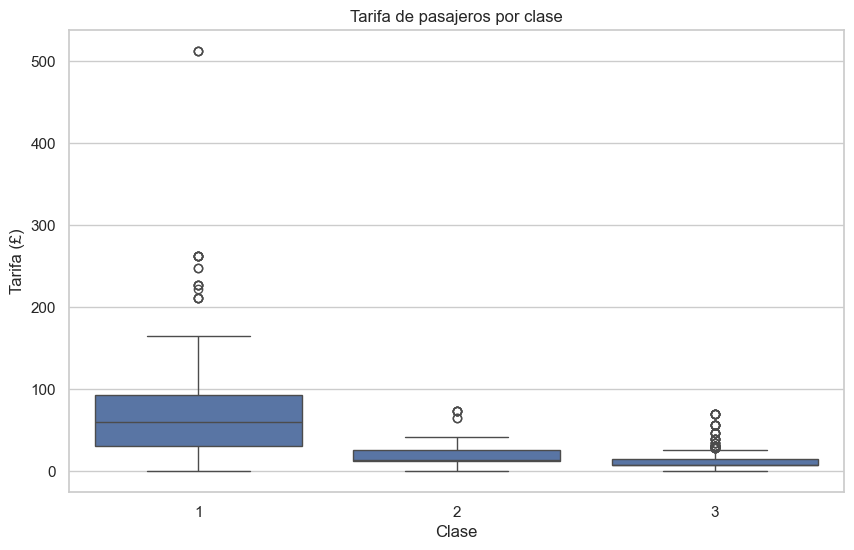

In [231]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Pclass", y="Fare")
plt.title("Tarifa de pasajeros por clase")
plt.ylabel("Tarifa (£)")
plt.xlabel("Clase")
plt.show()

## 2️⃣ Boxplots
Un boxplot se utiliza para **comparar distribuciones entre categorías**.
En este ejemplo, analizamos la **la edad entre sobrevivientes y no sobrevivientes**.

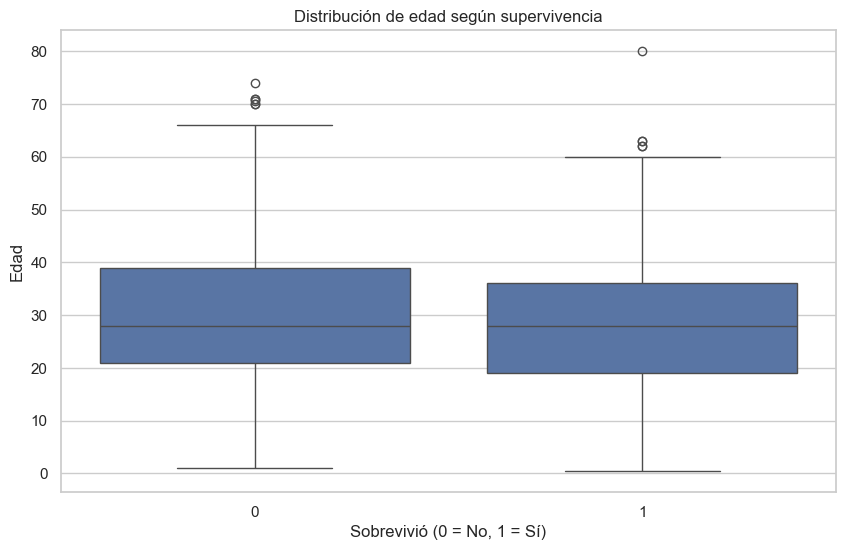

In [232]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Survived", y="Age")
plt.title("Distribución de edad según supervivencia")
plt.xlabel("Sobrevivió (0 = No, 1 = Sí)")
plt.ylabel("Edad")
plt.show()

## 3️⃣ Correlación
La correlación mide la **relación lineal entre variables**.
- +1 = relación positiva perfecta
- -1 = relación negativa perfecta
- 0 = no hay relación


In [233]:
corr = df_clean[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].corr()
corr

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


## 3️⃣➕ Scatter plots con línea de tendencia
A continuación se muestran diagramas de dispersión para pares de variables clave junto con la línea de regresión.
Se indica el coeficiente de correlación de Pearson (r) y su interpretación rápida:
- r > 0 → relación positiva
- r < 0 → relación negativa
- r ≈ 0 → sin relación lineal clara

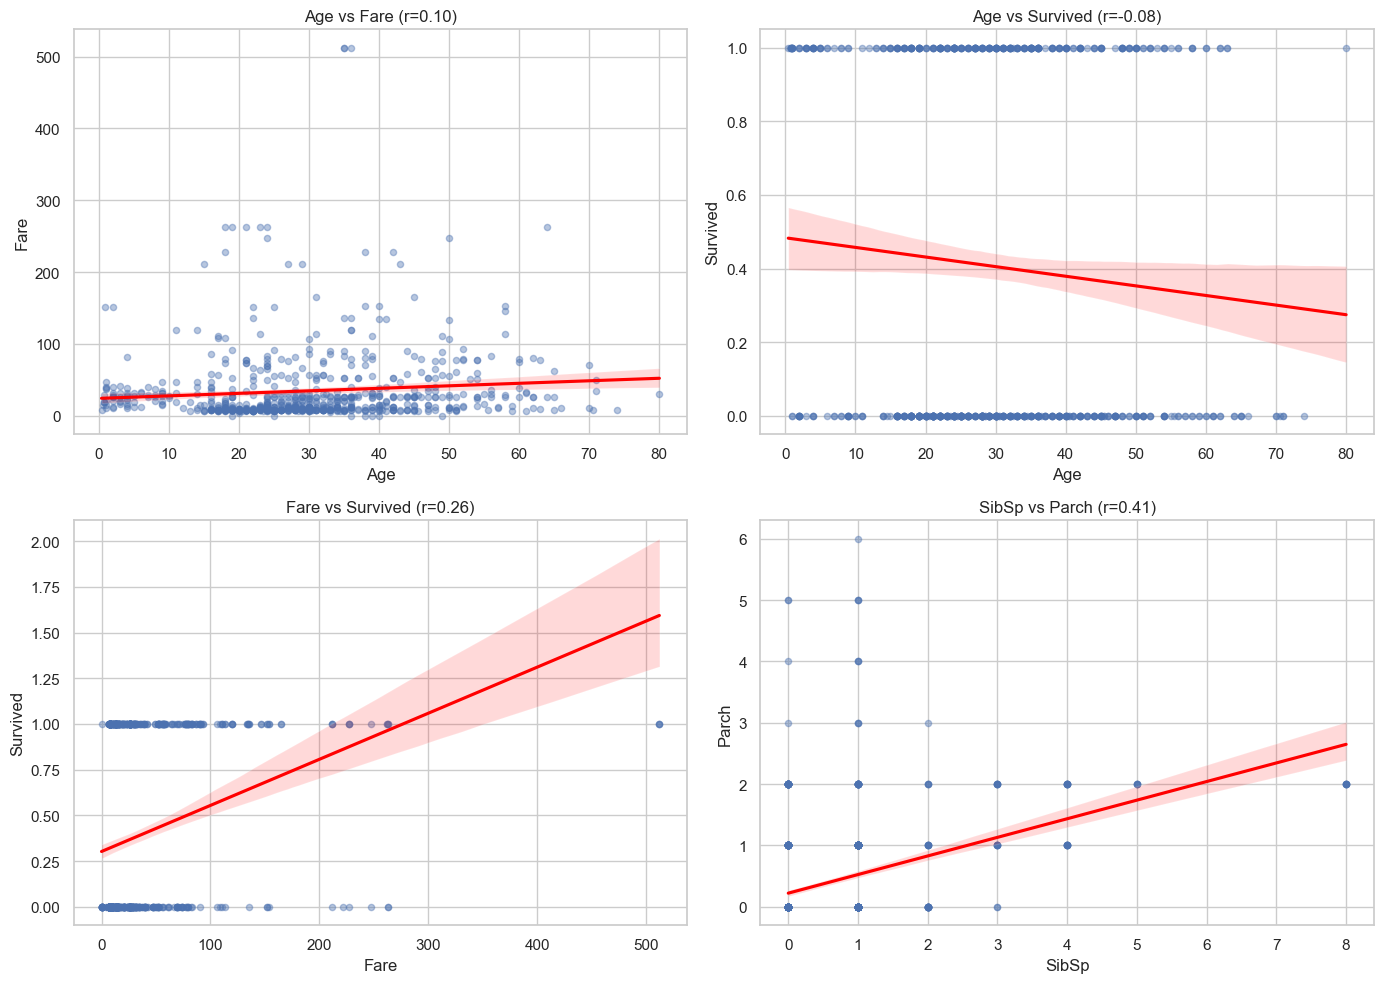


Interpretación rápida de correlaciones (scatter plots):
 - Age vs Fare: r=0.10 relación casi nula (p=0.0102)
 - Age vs Survived: r=-0.08 relación casi nula (p=0.0391)
 - Fare vs Survived: r=0.26 relación positiva (p=6.12e-15)
 - SibSp vs Parch: r=0.41 relación positiva (p=2.24e-38)


In [234]:
# Scatter plots con líneas de tendencia y r (sin dependencia obligatoria de SciPy)
import seaborn as sns
import matplotlib.pyplot as plt

# Intentar importar pearsonr; si no existe SciPy, se calcula r sin p-value
try:
    from scipy.stats import pearsonr  # type: ignore
    _has_scipy = True
except ImportError:  # SciPy no instalado
    _has_scipy = False

pairs = [
    ("Age", "Fare"),
    ("Age", "Survived"),
    ("Fare", "Survived"),
    ("SibSp", "Parch")
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
interpretaciones_scatter = []

for ax, (x, y) in zip(axes, pairs):
    sub = df_clean[[x, y]].dropna()
    if len(sub) < 2:
        ax.text(0.5, 0.5, 'Datos insuficientes', ha='center', va='center')
        ax.set_axis_off()
        continue
    # Calcular correlación
    if _has_scipy:
        r, p = pearsonr(sub[x], sub[y])  # precisa p-value
    else:
        r = sub[x].corr(sub[y])  # Pearson por defecto
        p = float('nan')
    sns.regplot(data=sub, x=x, y=y, ax=ax,
                scatter_kws={'alpha': 0.4, 's': 20},
                line_kws={'color': 'red'})
    ax.set_title(f"{x} vs {y} (r={r:.2f})")
    # Interpretación básica
    if r > 0.1:
        sentido = 'positiva'
    elif r < -0.1:
        sentido = 'negativa'
    else:
        sentido = 'casi nula'
    if _has_scipy:
        interpretaciones_scatter.append(f"{x} vs {y}: r={r:.2f} relación {sentido} (p={p:.3g})")
    else:
        interpretaciones_scatter.append(f"{x} vs {y}: r={r:.2f} relación {sentido} (p=N/A, SciPy no instalado)")

plt.tight_layout()
plt.show()

print("\nInterpretación rápida de correlaciones (scatter plots):")
for linea in interpretaciones_scatter:
    print(" - " + linea)

if not _has_scipy:
    print("\nNota: Instala SciPy (pip install scipy) para obtener p-values.")

## 4️⃣ Mapas de Calor
Un **heatmap** nos permite visualizar la matriz de correlaciones.
Los colores indican si la relación es **positiva o negativa**.

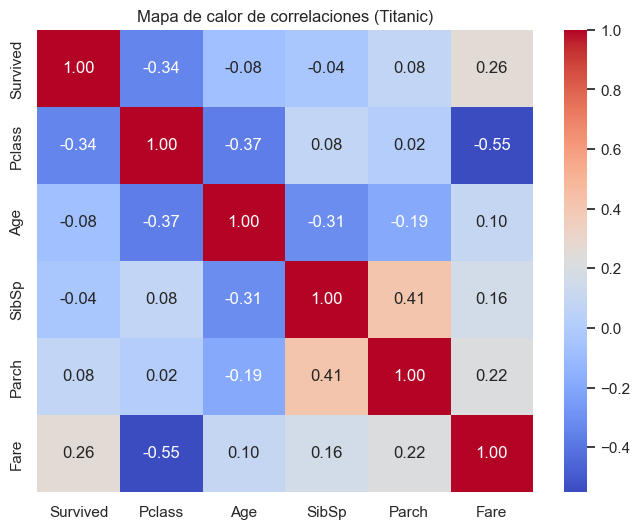

In [235]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlaciones (Titanic)")
plt.show()

# K-means

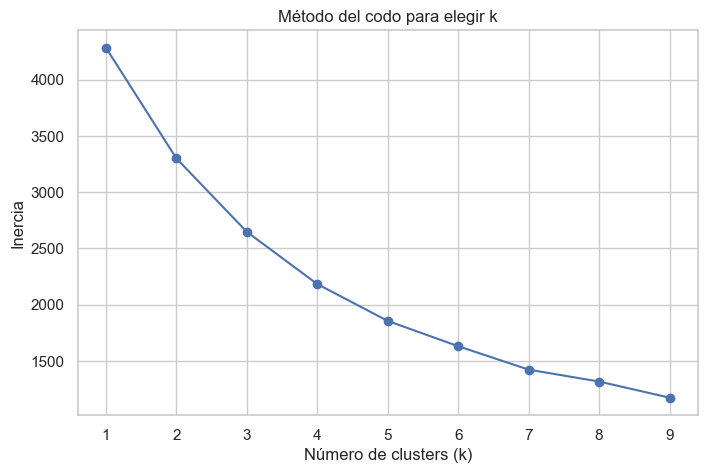

,Age,Fare,Pclass,SibSp,Parch,Survived
0,39.278564,88.650899,1.022099,0.458564,0.397790,6.685083e-01
1,22.626524,17.985874,2.469512,0.402439,0.548780,1.000000e+00
2,16.250000,36.711546,2.895833,2.895833,2.312500,1.041667e-01
3,29.922118,12.505398,2.704050,0.242991,0.109034,-8.881784e-16


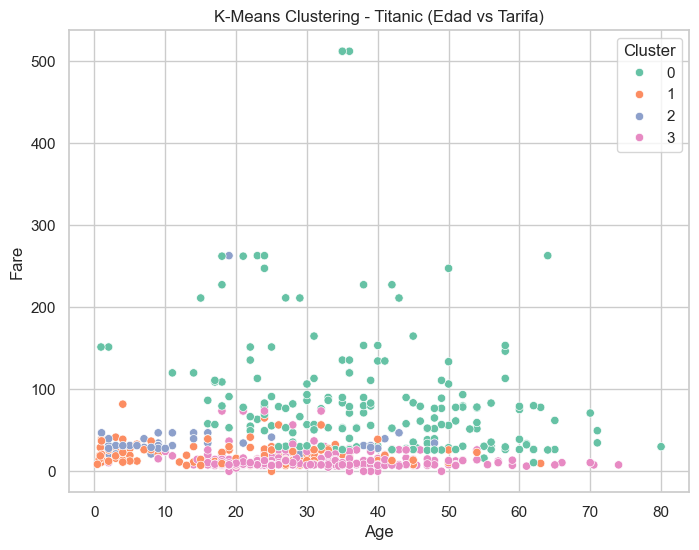

Cluster
0    0.67
1    1.00
2    0.10
3    0.00
Name: Survived, dtype: float64

In [236]:
# Selección de variables numéricas útiles
# Quitamos columnas no numéricas o irrelevantes (Name, Ticket, Cabin, Embarked, PassengerId)
df_numeric = df[["Age", "Fare", "Pclass", "SibSp", "Parch", "Survived"]].dropna()

# ⚖️ Estandarización de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric[["Age", "Fare", "Pclass", "SibSp", "Parch", "Survived"]])

# ⚙️ Método del codo para determinar k
inertia = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.title("Método del codo para elegir k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.show()

# 🔢 Elegimos k=4 (por el 'codo' en la gráfica)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Etiquetas de cluster
df_numeric["Cluster"] = kmeans.labels_

# Centros del clustering
centers = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers)
centers_df = pd.DataFrame(centers_original, columns=["Age", "Fare", "Pclass", "SibSp", "Parch", "Survived"])
display(centers_df)

#Visualización (Age vs Fare)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_numeric, x="Age", y="Fare", hue="Cluster", palette="Set2")
plt.title("K-Means Clustering - Titanic (Edad vs Tarifa)")
plt.show()

# Distancias entre centros
distances = cdist(centers, centers)
pd.DataFrame(distances, columns=[f"C{i}" for i in range(k)], index=[f"C{i}" for i in range(k)])

# Comparar supervivencia promedio por cluster (usamos "Survived")
survival_by_cluster = df_numeric.groupby("Cluster")["Survived"].mean().round(2)
display(survival_by_cluster)


# Resumen de Clusters (k=4)
Cluster 0:

-Adultos de clase alta, con tarifas altas

-Pocos familiares a bordo

-Supervivencia media-alta (≈67%)

=> Representa pasajeros de primera clase, coherente con los registros históricos.

Cluster 1:

-Jóvenes adultos, clase media (2ª clase)

-Tarifas moderadas, familias pequeñas

-Supervivencia muy alta (≈100%)

=> Posiblemente mujeres jóvenes o grupos con prioridad de rescate.

Cluster 2:

-Pasajeros muy jóvenes (≈16 años)

-Familias grandes (SibSp≈3, Parch≈2)

-Clase baja (3ª clase), tarifas medias

-Supervivencia muy baja (≈10%)

=> Familias numerosas en tercera clase con bajo acceso a botes.

Cluster 3:

-Adultos jóvenes de clase baja (≈3ª clase)

-Tarifas bajas, casi sin familiares

-Supervivencia nula (≈0%)

=> Principalmente hombres adultos en tercera clase.

**Conclusión general**

Los clusters 0 y 1 presentan alta supervivencia, asociados a clases altas o prioridad de rescate.
Los clusters 2 y 3 concentran la menor supervivencia, vinculados a pasajeros de clase baja o familias grandes.
El clustering confirma la influencia del nivel socioeconómico y la composición familiar en las probabilidades de supervivencia del Titanic.